In [2]:
# %pip install matplotlib seaborn -q
!pip install hdbscan
!pip install umap-learn

  Using cached hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached umap_learn-0.5.5-py3-none-any.whl
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/4e/82/0b9851a2fd4da9b57d7931446f5ebab92a98f1f35d3dc0dae5f9ed50a462/pynndescent-0.5.11-py3-none-any.whl.metadata
  Using cached pynndescent-0.5.11-py3-none-any.whl.metadata (6.8 kB)
  Using cached numpy-1.21.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
Using cached pynndescent-0.5.11-py3-none-any.whl (55 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 

In [18]:
import sys
sys.path.append('../')
import io

# import warnings
import boto3
# import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn import metrics, preprocessing

from denseclus import DenseClus

# %matplotlib inline


# warnings.filterwarnings("ignore")

In [19]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

### Data
Let's start by downloading publicly available Census Income dataset available at https://archive.ics.uci.edu/ml/datasets/Adult. In this dataset we have different attributes such as age, work class, education, country, race etc for each person. We also have an indicator of person's income being more than $50K a year. The prediction task is to determine whether a person makes over 50K a year.


## Data Description
Let's talk about the data. At a high level, we can see:

- There are 15 columns and around 32K rows in the training data
- IncomeGroup is the target field

Specifics on the features:

- 9 of the 14 features are categorical and remaining 5 are numeric

Target variable:
- IncomeGroup_>50K: Whether or not annual income was more than 50K

Now lets read this into a Pandas data frame and take a look.

In [49]:
s3 = boto3.client("s3")

## read the data
s3.download_file(f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data", "adult.data")
data = pd.read_csv("adult.data", header=None)

## set column names
data.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

In [39]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting a groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

In [40]:
def fit_denseclus(data, umap_combine_method):
    hdbscan_params = {"cluster_selection_method": "leaf"}

    clf = DenseClus(
        random_state=SEED,
        umap_combine_method=umap_combine_method,
        hdbscan_params=hdbscan_params,
    )
    clf.fit(data)
    
    return clf

### umap_combine_method = intersection_union_mapper

In [42]:
clf_intersection_union_mapper = fit_denseclus(data, "intersection_union_mapper")

Max of 42 is greater than threshold 25
Hashing categorical features


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
IOStream.flush timed out
IOStream.flush timed out


In [43]:
clf_intersection_union_mapper.score

<bound method DenseClus.score of DenseClus(random_state=42
                            ,umap_combine_method=intersection_union_mapper
                            ,umap_params={'categorical': {'metric': 'dice', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'numerical': {'metric': 'l2', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'combined': {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 5}}
                            ,hdbscan_params={'cluster_selection_method': 'leaf'})>

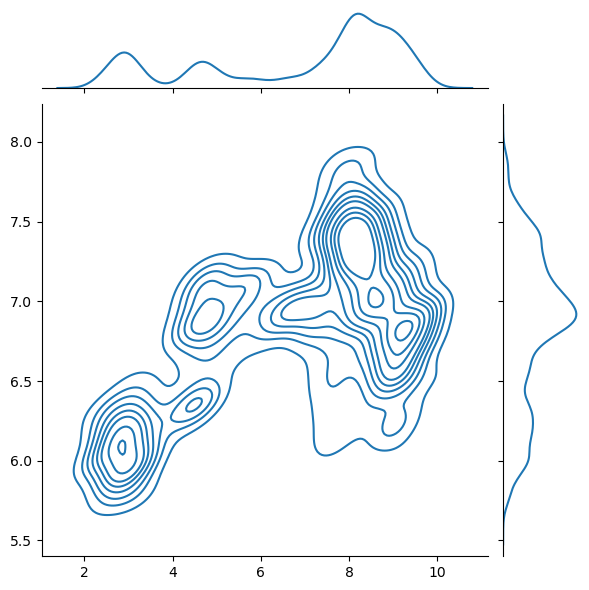

In [ ]:
_ = sns.jointplot(x=clf_intersection_union_mapper.mapper_.embedding_[:, 0], y=clf_intersection_union_mapper.mapper_.embedding_[:, -1], kind="kde")

### umap_combine_method = intersection

In [44]:
clf_intersection = fit_denseclus(data, "intersection")

Max of 42 is greater than threshold 25
Hashing categorical features


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [45]:
clf_intersection.score

<bound method DenseClus.score of DenseClus(random_state=42
                            ,umap_combine_method=intersection
                            ,umap_params={'categorical': {'metric': 'dice', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'numerical': {'metric': 'l2', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'combined': {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 5}}
                            ,hdbscan_params={'cluster_selection_method': 'leaf'})>

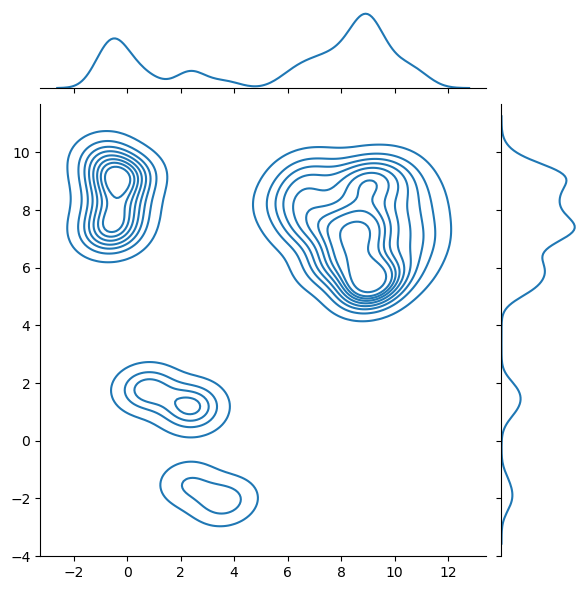

In [50]:
_ = sns.jointplot(x=clf_intersection.mapper_.embedding_[:, 0], y=clf_intersection.mapper_.embedding_[:, -1], kind="kde")

### umap_combine_method = union

In [ ]:
clf_union = fit_denseclus(data, "union")

Max of 42 is greater than threshold 25
Hashing categorical features


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [52]:
clf_union.score

<bound method DenseClus.score of DenseClus(random_state=42
                            ,umap_combine_method=union
                            ,umap_params={'categorical': {'metric': 'dice', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'numerical': {'metric': 'l2', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'combined': {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 5}}
                            ,hdbscan_params={'cluster_selection_method': 'leaf'})>

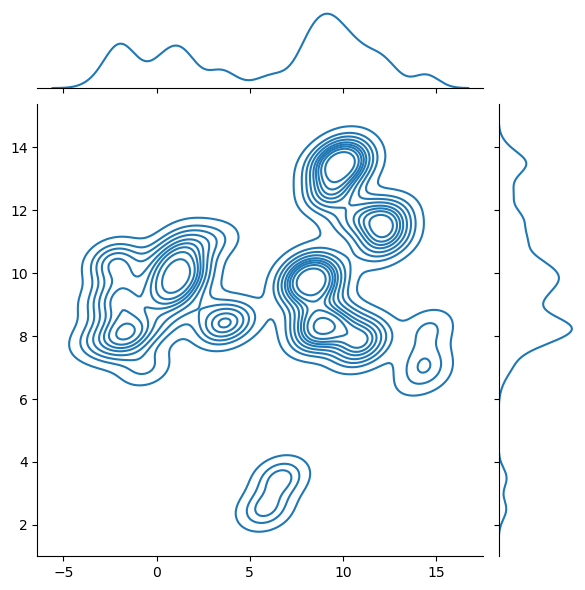

In [51]:
_ = sns.jointplot(x=clf_union.mapper_.embedding_[:, 0], y=clf_union.mapper_.embedding_[:, -1], kind="kde")

### umap_combine_method = contrast

In [53]:
clf_contrast = fit_denseclus(data, "contrast")

Max of 42 is greater than threshold 25
Hashing categorical features


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:2277: UserWarning: Combined graph is not connected but mult-component layout is unsupported. Falling back to random initialization.
  warn(


In [55]:
clf_contrast.score

<bound method DenseClus.score of DenseClus(random_state=42
                            ,umap_combine_method=contrast
                            ,umap_params={'categorical': {'metric': 'dice', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'numerical': {'metric': 'l2', 'n_neighbors': 30, 'n_components': 5, 'min_dist': 0.0}, 'combined': {'n_neighbors': 30, 'min_dist': 0.0, 'n_components': 5}}
                            ,hdbscan_params={'cluster_selection_method': 'leaf'})>

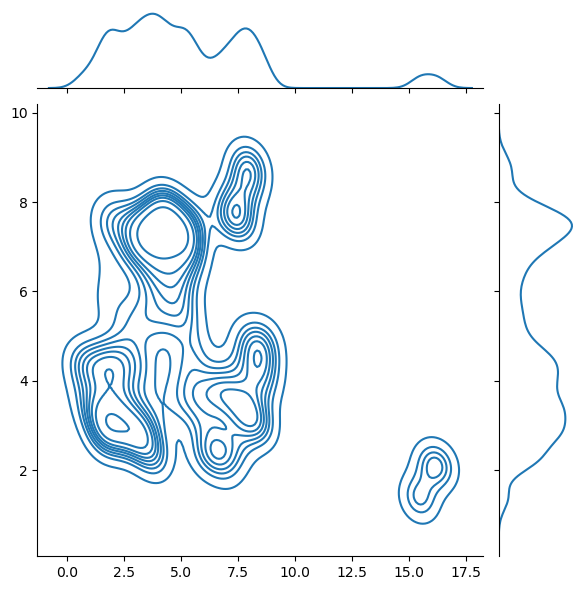

In [54]:
_ = sns.jointplot(x=clf_contrast.mapper_.embedding_[:, 0], y=clf_contrast.mapper_.embedding_[:, -1], kind="kde")